In [1]:
!pip install pygad

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Concatenate,
    Reshape,
    BatchNormalization
)
from sklearn.model_selection import train_test_split

# Constants
IMG_HEIGHT = 50
IMG_WIDTH = 200
IMG_CHANNELS = 1
NUM_CLASSES = 36  # Digits 0-9 + letters a-z
CAPTCHA_LENGTH = 5  # Fixed number of characters in CAPTCHA

# Character set
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"

# Preprocess images and targets
def preprocess_data(image_dir):
    images = []
    labels = []

    for filename in os.listdir(image_dir):
        # Read and preprocess image
        img_path = os.path.join(image_dir, filename)
        img = tf.keras.preprocessing.image.load_img(
            img_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH)
        )
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img)

        # Extract label from filename
        label = filename[:-4]  # Remove ".png"
        label_one_hot = np.zeros((CAPTCHA_LENGTH, NUM_CLASSES))  # Shape (5, 36)
        for i, char in enumerate(label):
            label_one_hot[i, CHAR_SET.index(char)] = 1
        labels.append(label_one_hot)

    images = np.array(images)  # Shape (n_samples, 50, 200, 1)
    labels = np.array(labels)  # Shape (n_samples, 5, 36)
    return images, labels

# Load data
image_dir = "samples\samples"  # Update this path
X, y = preprocess_data(image_dir)

In [4]:
import os
print(os.listdir("../input"))

['samples']


In [5]:
y

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

  

In [6]:
len(y[0])

5

In [7]:
display(X[0])

array([[[0.7529412 ],
        [0.7529412 ],
        [0.7529412 ],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.9843137 ]],

       [[0.7529412 ],
        [0.7529412 ],
        [0.7529412 ],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.9843137 ]],

       [[0.7529412 ],
        [0.7529412 ],
        [0.7529412 ],
        ...,
        [0.9843137 ],
        [0.9843137 ],
        [0.9843137 ]],

       ...,

       [[0.7647059 ],
        [0.7647059 ],
        [0.7647059 ],
        ...,
        [0.99607843],
        [0.99607843],
        [0.99607843]],

       [[0.7647059 ],
        [0.7647059 ],
        [0.7647059 ],
        ...,
        [0.99607843],
        [0.99607843],
        [0.99607843]],

       [[0.7647059 ],
        [0.7647059 ],
        [0.7647059 ],
        ...,
        [0.99607843],
        [0.99607843],
        [0.99607843]]], dtype=float32)

<!-- experiment -->
experimented code.

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Below code is reshaping code without genetic.

In [6]:

# Build the model
def build_model():
    # Input layer
    img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Convolutional layers
    x = Conv2D(16, (3, 3), padding="same", activation="relu")(img_input)
    x = MaxPooling2D(padding="same")(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(padding="same")(x)
    x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(padding="same")(x)

    # Flatten the convolutional output
    x = Flatten()(x)

    # Independent dense layers for each character
    outputs = []
    for _ in range(CAPTCHA_LENGTH):
        dense = Dense(64, activation="relu")(x)
        drop = Dropout(0.5)(dense)
        char_output = Dense(NUM_CLASSES, activation="softmax")(drop)
        outputs.append(char_output)

    # Concatenate outputs along the character axis
    concatenated_output = Concatenate(axis=1)(outputs)  # Shape: (batch_size, 5 * 36)

    # Reshape to (batch_size, 5, 36)
    reshaped_output = Reshape((CAPTCHA_LENGTH, NUM_CLASSES))(concatenated_output)

    # Model definition
    model = Model(inputs=img_input, outputs=reshaped_output)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model




# Build and train the model
model = build_model()
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
print("Test Accuracy:", test_accuracy)

# Predict on test data
predictions = model.predict(X_test)

# Decode predictions
def decode_predictions(predictions):
    decoded_captchas = []
    for i in range(predictions.shape[0]):  # Iterate over batch
        captcha = ""
        for char_probs in predictions[i]:  # Iterate over characters
            char_index = np.argmax(char_probs)  # Get most probable class
            captcha += CHAR_SET[char_index]
        decoded_captchas.append(captcha)
    return decoded_captchas

decoded_captchas = decode_predictions(predictions)
print("Sample Decoded Captchas:", decoded_captchas[:10])

Epoch 1/30
22/22 [==============================] - 6s 132ms/step - loss: 3.4875 - accuracy: 0.0579 - val_loss: 3.3865 - val_accuracy: 0.0686
Epoch 2/30
22/22 [==============================] - 3s 114ms/step - loss: 3.3693 - accuracy: 0.0681 - val_loss: 3.2500 - val_accuracy: 0.0826
Epoch 3/30
22/22 [==============================] - 3s 115ms/step - loss: 3.2485 - accuracy: 0.0854 - val_loss: 3.1131 - val_accuracy: 0.1233
Epoch 4/30
22/22 [==============================] - 3s 114ms/step - loss: 3.0699 - accuracy: 0.1096 - val_loss: 2.8425 - val_accuracy: 0.1663
Epoch 5/30
22/22 [==============================] - 2s 112ms/step - loss: 2.7139 - accuracy: 0.1906 - val_loss: 2.3688 - val_accuracy: 0.3314
Epoch 6/30
22/22 [==============================] - 2s 111ms/step - loss: 2.3142 - accuracy: 0.2795 - val_loss: 2.0133 - val_accuracy: 0.4233
Epoch 7/30
22/22 [==============================] - 3s 117ms/step - loss: 2.0187 - accuracy: 0.3494 - val_loss: 1.6403 - val_accuracy: 0.5605
Epoch 

### With genetic experiments.

In [ ]:
import pygad.kerasga
import pygad
import warnings
warnings.filterwarnings("ignore")



# Build the model with independent filters for each layer
def build_model(hyperparams):
    filters1 = int(hyperparams[0])
    filters2 = int(hyperparams[1])
    filters3 = int(hyperparams[2])
    dense_units = int(hyperparams[3])

    # Input layer
    img_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Convolutional layers with independent filters
    x = Conv2D(filters1, (3, 3), padding="same", activation="relu")(img_input)
    x = MaxPooling2D(padding="same")(x)
    x = Conv2D(filters2, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(padding="same")(x)
    x = Conv2D(filters3, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(padding="same")(x)

    # Flatten the convolutional output
    x = Flatten()(x)

    # Independent dense layers for each character
    outputs = []
    for _ in range(CAPTCHA_LENGTH):
        dense = Dense(dense_units, activation="relu")(x)
        drop = Dropout(0.5)(dense)
        char_output = Dense(NUM_CLASSES, activation="softmax")(drop)
        outputs.append(char_output)

    # Concatenate outputs along the character axis
    concatenated_output = Concatenate(axis=1)(outputs)  # Shape: (batch_size, 5 * 36)

    # Reshape to (batch_size, 5, 36)
    reshaped_output = Reshape((CAPTCHA_LENGTH, NUM_CLASSES))(concatenated_output)

    # Model definition
    model = Model(inputs=img_input, outputs=reshaped_output)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Fitness function for GA
def fitness_func(ga_instance, solution, sol_idx):
    # Extract hyperparameters from the solution
    filters1 = int(solution[0])
    filters2 = int(solution[1])
    filters3 = int(solution[2])
    dense_units = int(solution[3])

    # Build and train the model
    model = build_model([filters1, filters2, filters3, dense_units])

    subset_size = 300  # Number of samples to use for evaluation
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
 
    history = model.fit(
        X_train_subset,
        y_train_subset,
        batch_size=16,
        epochs=3,  # Use fewer epochs for quicker GA evaluation
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Calculate accuracy
    accuracy = history.history["val_accuracy"][-1]
    return accuracy

def on_generation(ga_instance):
    best_solution, best_fitness, _ = ga_instance.best_solution()
    print(f"Generation {ga_instance.generations_completed}:")
    print(f"  Best Fitness: {best_fitness}")
    print(f"  Best Solution (Parameters): {best_solution}")
    

# Define GA hyperparameters
gene_space = [
    {'low': 16, 'high': 24},  # Narrow Filters for Conv Layer 1
    {'low': 32, 'high': 48}, # Narrow Filters for Conv Layer 2
    {'low': 48, 'high': 64}, # Narrow Filters for Conv Layer 3
    {'low': 64, 'high': 128}, # Narrow Dense layer units
]

ga_instance = pygad.GA(
    num_generations=4,  # Number of generations
    num_parents_mating=4,  # Number of parents for crossover
    fitness_func=fitness_func,
    sol_per_pop=4,  # Population size
    num_genes=4,  # 3 filters, 1 dense units
    gene_space=gene_space,
    mutation_percent_genes=30,  # Higher mutation rate
    crossover_probability=0.8,  # Encourage more crossover
    keep_parents=2,  # Retain the best parents
    on_generation=on_generation
)

# Run GA
ga_instance.run()

# Best solution from GA
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print("Best Solution:", best_solution)
print("Best Solution Fitness:", best_solution_fitness)

# Build and save the best model
best_model = build_model(best_solution)
best_model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2)
best_model.save("best_captcha_model1.h5")

Generation 1:
  Best Fitness: 0.11000000685453415
  Best Solution (Parameters): [ 19.20382941  34.41133138  52.2624707  102.73579591]
Generation 2:
  Best Fitness: 0.1133333370089531
  Best Solution (Parameters): [19.20382941 34.41133138 52.29903119 81.36454443]
Generation 3:
  Best Fitness: 0.11999999731779099
  Best Solution (Parameters): [ 18.18180064  33.57221752  52.78853115 102.73579591]
Generation 4:
  Best Fitness: 0.11999999731779099
  Best Solution (Parameters): [ 18.18180064  33.57221752  52.78853115 102.73579591]
Best Solution: [ 18.18180064  33.57221752  52.78853115 102.73579591]
Best Solution Fitness: 0.11999999731779099
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.0458 - loss: 3.4779 - val_accuracy: 0.0756 - val_loss: 3.2521
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0647 - loss: 3.2642 - val_accuracy: 0.1081 - val_loss: 3.0820
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0852 - loss: 3.0932 - val_accuracy: 0

In [30]:
k1=best_solution

In [18]:
# bsolution= [20.06142429,40.51892279,50.20829043,91.33879553]
# k=build_model(bsolution)

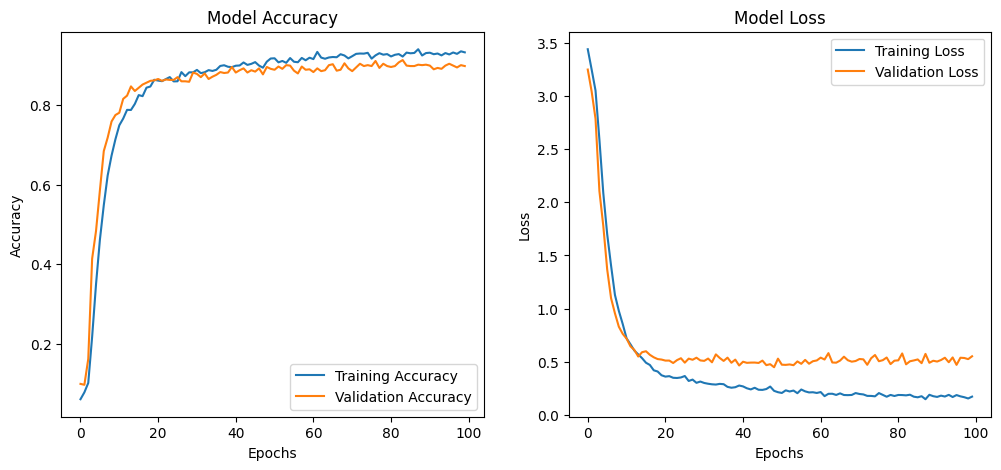

In [31]:
import matplotlib.pyplot as plt

k=build_model(best_solution)
history= k.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2,verbose=0)

best_model.save("best_captcha_model.h5")
# Plot accuracy and loss curves
def plot_training_history(history):
    # Extract accuracy and loss values
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_training_history(history)


In [32]:

# Evaluate the model
test_loss, test_accuracy = k.evaluate(X_test, y_test, batch_size=32)
print("Test Accuracy:", test_accuracy)

# Predict on test data
predictions = model.predict(X_test)

# Decode predictions
def decode_predictions(predictions):
    decoded_captchas = []
    for i in range(predictions.shape[0]):  # Iterate over batch
        captcha = ""
        for char_probs in predictions[i]:  # Iterate over characters
            char_index = np.argmax(char_probs)  # Get most probable class
            captcha += CHAR_SET[char_index]
        decoded_captchas.append(captcha)
    return decoded_captchas

decoded_captchas = decode_predictions(predictions)
print("Sample Decoded Captchas:", decoded_captchas[:10])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9247 - loss: 0.4015
Test Accuracy: 0.9186916351318359
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Sample Decoded Captchas: ['pybce', '2nbcx', 'ndg2b', 'f6ne5', '6bxwg', 'xbebx', '8np22', '6dd2y', 'pg2yc', '2cg58']
